# **Stock market prediction**
# using PyTorch RNN and LSTM

In [44]:
# !pip install torch

## Import data

In [45]:
# importing necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [46]:
data = pd.read_csv('GOOG.csv')
data

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,GOOG,2016-06-14 00:00:00+00:00,718.27,722.470,713.1200,716.48,1306065,718.27,722.470,713.1200,716.48,1306065,0.0,1.0
1,GOOG,2016-06-15 00:00:00+00:00,718.92,722.980,717.3100,719.00,1214517,718.92,722.980,717.3100,719.00,1214517,0.0,1.0
2,GOOG,2016-06-16 00:00:00+00:00,710.36,716.650,703.2600,714.91,1982471,710.36,716.650,703.2600,714.91,1982471,0.0,1.0
3,GOOG,2016-06-17 00:00:00+00:00,691.72,708.820,688.4515,708.65,3402357,691.72,708.820,688.4515,708.65,3402357,0.0,1.0
4,GOOG,2016-06-20 00:00:00+00:00,693.71,702.480,693.4100,698.77,2082538,693.71,702.480,693.4100,698.77,2082538,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,GOOG,2021-06-07 00:00:00+00:00,2466.09,2468.000,2441.0725,2451.32,1192453,2466.09,2468.000,2441.0725,2451.32,1192453,0.0,1.0
1254,GOOG,2021-06-08 00:00:00+00:00,2482.85,2494.495,2468.2400,2479.90,1253253,2482.85,2494.495,2468.2400,2479.90,1253253,0.0,1.0
1255,GOOG,2021-06-09 00:00:00+00:00,2491.40,2505.000,2487.3300,2499.50,1006337,2491.40,2505.000,2487.3300,2499.50,1006337,0.0,1.0
1256,GOOG,2021-06-10 00:00:00+00:00,2521.60,2523.260,2494.0000,2494.01,1561733,2521.60,2523.260,2494.0000,2494.01,1561733,0.0,1.0


In [47]:
data.columns

Index(['symbol', 'date', 'close', 'high', 'low', 'open', 'volume', 'adjClose',
       'adjHigh', 'adjLow', 'adjOpen', 'adjVolume', 'divCash', 'splitFactor'],
      dtype='object')

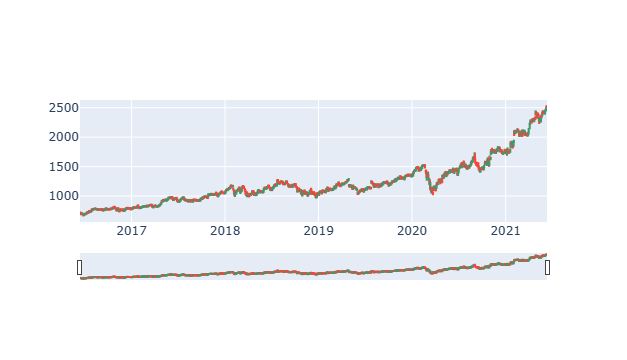

In [48]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=data['date'],
                open= data['open'],
                high= data['high'],
                low= data['low'],
                close= data['close'])])
fig.show()

In [49]:
data = data[['date','close']]
data

,date,close
0,2016-06-14 00:00:00+00:00,718.27
1,2016-06-15 00:00:00+00:00,718.92
2,2016-06-16 00:00:00+00:00,710.36
3,2016-06-17 00:00:00+00:00,691.72
4,2016-06-20 00:00:00+00:00,693.71
...,...,...
1253,2021-06-07 00:00:00+00:00,2466.09
1254,2021-06-08 00:00:00+00:00,2482.85
1255,2021-06-09 00:00:00+00:00,2491.40
1256,2021-06-10 00:00:00+00:00,2521.60


In [50]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

C:\Users\Rashi Bhatnagar\AppData\Local\Temp\ipykernel_9268\2670177637.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



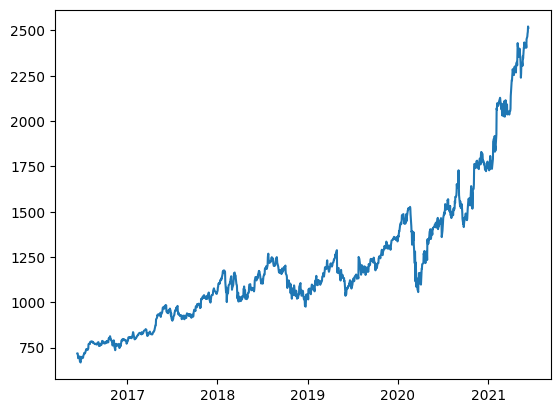

In [51]:
data['date'] = pd.to_datetime(data['date'])

plt.plot(data['date'], data['close'])

## Data Preprocessing

In [52]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'close(t-{i})'] = df['close'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,close,close(t-1),close(t-2),close(t-3),close(t-4),close(t-5),close(t-6),close(t-7)
date,,,,,,,,
2016-06-23 00:00:00+00:00,701.87,697.46,695.94,693.71,691.72,710.36,718.92,718.27
2016-06-24 00:00:00+00:00,675.22,701.87,697.46,695.94,693.71,691.72,710.36,718.92
2016-06-27 00:00:00+00:00,668.26,675.22,701.87,697.46,695.94,693.71,691.72,710.36
2016-06-28 00:00:00+00:00,680.04,668.26,675.22,701.87,697.46,695.94,693.71,691.72
2016-06-29 00:00:00+00:00,684.11,680.04,668.26,675.22,701.87,697.46,695.94,693.71
...,...,...,...,...,...,...,...,...
2021-06-07 00:00:00+00:00,2466.09,2451.76,2404.61,2421.28,2429.81,2411.56,2402.51,2433.53
2021-06-08 00:00:00+00:00,2482.85,2466.09,2451.76,2404.61,2421.28,2429.81,2411.56,2402.51
2021-06-09 00:00:00+00:00,2491.40,2482.85,2466.09,2451.76,2404.61,2421.28,2429.81,2411.56


In [53]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[ 701.87,  697.46,  695.94, ...,  710.36,  718.92,  718.27],
       [ 675.22,  701.87,  697.46, ...,  691.72,  710.36,  718.92],
       [ 668.26,  675.22,  701.87, ...,  693.71,  691.72,  710.36],
       ...,
       [2491.4 , 2482.85, 2466.09, ..., 2421.28, 2429.81, 2411.56],
       [2521.6 , 2491.4 , 2482.85, ..., 2404.61, 2421.28, 2429.81],
       [2513.93, 2521.6 , 2491.4 , ..., 2451.76, 2404.61, 2421.28]])

In [54]:
shifted_df_as_np.shape

(1251, 8)

In [55]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.96373035, -0.96848932, -0.96963481, ..., -0.95278946,
        -0.94260368, -0.94334011],
       [-0.99248924, -0.96373035, -0.96796735, ..., -0.97369218,
        -0.95230191, -0.94260368],
       [-1.        , -0.99248924, -0.96312955, ..., -0.97146061,
        -0.9734205 , -0.95230191],
       ...,
       [ 0.96741019,  0.9581836 ,  0.97223472, ...,  0.96582002,
         0.99578535,  0.97510862],
       [ 1.        ,  0.96741019,  0.99062058, ...,  0.94712644,
         0.9861211 ,  0.99578535],
       [ 0.99172305,  1.        ,  1.        , ...,  1.        ,
         0.96723447,  0.9861211 ]])

In [56]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((1251, 7), (1251,))

In [57]:
X = dc(np.flip(X, axis=1))
X

array([[-0.94334011, -0.94260368, -0.95278946, ..., -0.97194959,
        -0.96963481, -0.96848932],
       [-0.94260368, -0.95230191, -0.97369218, ..., -0.96949173,
        -0.96796735, -0.96373035],
       [-0.95230191, -0.9734205 , -0.97146061, ..., -0.96781642,
        -0.96312955, -0.99248924],
       ...,
       [ 0.97510862,  0.99578535,  0.96582002, ...,  0.96573331,
         0.97223472,  0.9581836 ],
       [ 0.99578535,  0.9861211 ,  0.94712644, ...,  0.98152751,
         0.99062058,  0.96741019],
       [ 0.9861211 ,  0.96723447,  1.        , ...,  1.        ,
         1.        ,  1.        ]])

In [58]:
split_index = int(len(X) * 0.95)

split_index

1188

### Train test split

In [59]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1188, 7), (63, 7), (1188,), (63,))

In [60]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1188, 7, 1), (63, 7, 1), (1188, 1), (63, 1))

In [61]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([1188, 7, 1]),
 torch.Size([63, 7, 1]),
 torch.Size([1188, 1]),
 torch.Size([63, 1]))

### Defining train and test loaders

In [62]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [63]:
train_dataset

In [64]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [65]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    print(x_batch.dtype, y_batch.dtype)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])
torch.float32 torch.float32


## Implementing RNN

In [66]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.rnn = nn.RNN(input_size, hidden_size, num_stacked_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

model = RNN(1, 4, 1).to(device)

In [67]:
def train_one_epoch():
    model.train(True)
    # print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print(f'Epoch: {epoch + 1}')
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1, avg_loss_across_batches))
            running_loss = 0.0

In [68]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    if batch_index % 10 == 1:
      print(f'Epoch: {epoch + 1}')
      print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
      print('***************************************************')

In [69]:
learning_rate = 0.001
num_epochs = 100
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

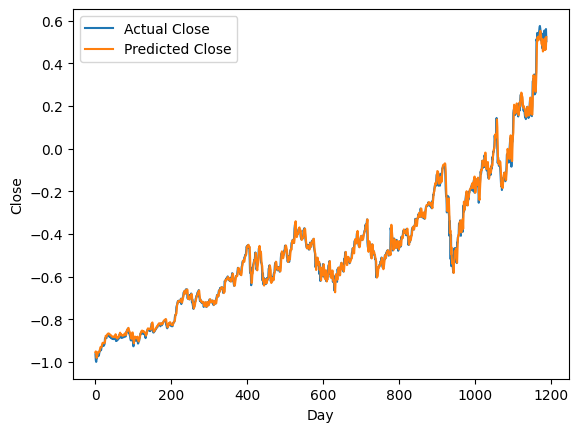

In [70]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [71]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])

In [72]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([ 701.87001025,  675.2200157 ,  668.26      , ..., 2055.03000945,
       2114.76998768, 2061.91998864])

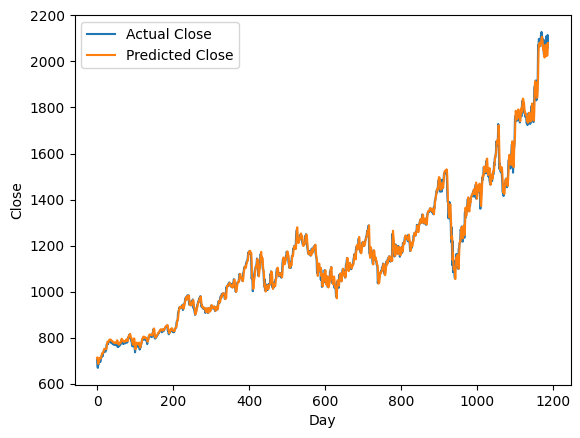

In [73]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [74]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([2073.1742694 , 2045.3549193 , 2066.72489052, 2075.95435407,
       2041.52511557, 2020.97017484, 2024.95507518, 2036.21416129,
       2039.06312256, 2032.01373851, 2026.32476385, 2035.98223441,
       2045.50062616, 2052.19441477, 2100.81576654, 2178.34783378,
       2202.78030028, 2205.45880993, 2218.23864924, 2232.57470189,
       2221.75853592, 2214.92843021, 2214.27059522, 2234.12202258,
       2251.16641115, 2249.41875734, 2245.39850734, 2240.11992008,
       2227.16443717, 2246.0094488 , 2270.98646568, 2259.95726281,
       2292.63901321, 2341.99188191, 2342.14786226, 2322.77658264,
       2294.00146624, 2284.57128293, 2304.30285286, 2322.00861138,
       2294.96225882, 2254.77257308, 2207.20806552, 2201.37962543,
       2250.09327294, 2270.87677129, 2258.16845979, 2250.46278731,
       2279.68016103, 2290.37762949, 2316.69384596, 2336.33836737,
       2343.88816997, 2334.97851033, 2326.08641504, 2342.20740434,
       2342.35896598, 2330.53638429, 2349.62033749, 2372.68322

In [75]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([2066.48998101, 2092.51997575, 2091.07997441, 2036.21998846,
       2043.1999988 , 2038.58998951, 2052.96001097, 2045.05999823,
       2044.35999221, 2035.55000202, 2055.95001184, 2055.54001108,
       2068.63001599, 2137.75002522, 2225.55000737, 2224.75000049,
       2249.68001338, 2265.43999432, 2285.87999344, 2254.79002697,
       2267.27000178, 2254.84001359, 2296.65998125, 2297.76001833,
       2302.39999197, 2293.63001869, 2293.2899992 , 2267.91999357,
       2315.30002011, 2326.73999702, 2307.11999944, 2379.91002091,
       2429.89001459, 2410.1200019 , 2395.17002517, 2354.2499824 ,
       2356.73997897, 2381.35002225, 2398.69002231, 2341.65998179,
       2308.7600025 , 2239.07997741, 2261.9699838 , 2316.16001094,
       2321.40998707, 2303.42999255, 2308.71001588, 2356.08998719,
       2345.10000034, 2406.66998603, 2409.07000668, 2433.52997962,
       2402.50999442, 2411.56000325, 2429.80998076, 2421.2799985 ,
       2404.60998487, 2451.76001772, 2466.08999465, 2482.84998

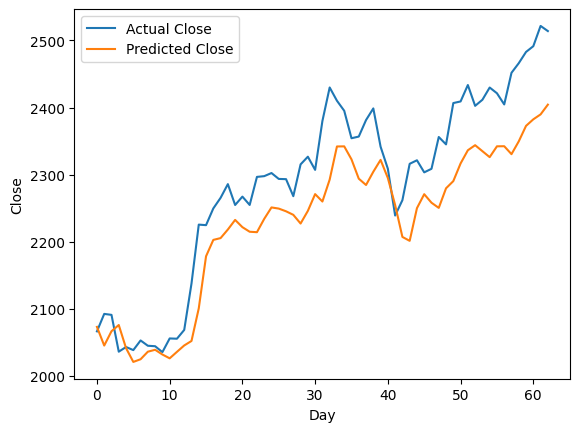

In [76]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

## Implementing LSTM

In [77]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [78]:
learning_rate = 0.001
num_epochs = 100
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

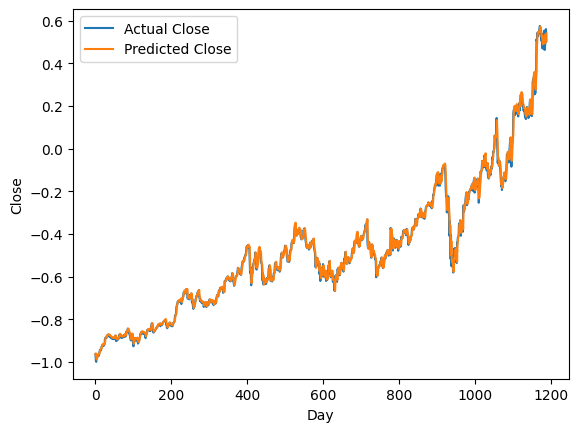

In [79]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [80]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([ 701.96954162,  705.55289198,  689.99131097, ..., 2057.76524425,
       2060.15918918, 2095.38826886])

In [81]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([ 701.87001025,  675.2200157 ,  668.26      , ..., 2055.03000945,
       2114.76998768, 2061.91998864])

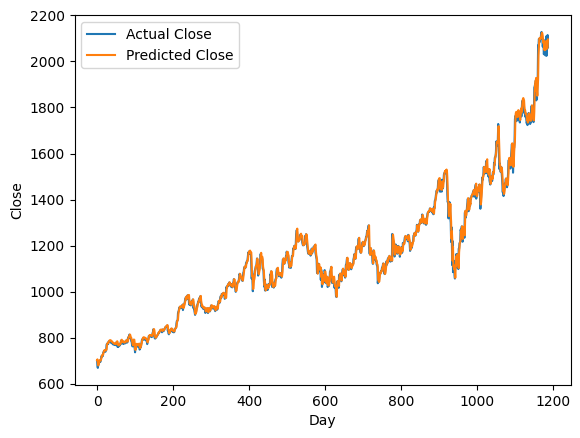

In [82]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [83]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([2079.45104254, 2076.15584711, 2089.92188657, 2093.37913807,
       2063.5304416 , 2054.79565228, 2048.72490135, 2054.18189389,
       2052.16177157, 2051.98137786, 2047.20679936, 2056.65371853,
       2060.25971476, 2069.45741886, 2112.27419156, 2175.34935452,
       2200.94808347, 2223.93861543, 2240.41696765, 2255.64598573,
       2247.16814421, 2248.93662118, 2243.92796168, 2260.128322  ,
       2267.44199995, 2273.24370687, 2272.54687679, 2271.93289747,
       2260.24458923, 2275.30254811, 2286.53617141, 2283.69615803,
       2312.97948095, 2344.57527889, 2351.8438308 , 2350.32015019,
       2334.42169802, 2327.63373573, 2332.46487368, 2340.73879187,
       2323.04126318, 2302.26494524, 2262.03703768, 2252.48760451,
       2270.58088363, 2280.89287514, 2279.52423591, 2282.17010237,
       2303.16045143, 2307.02720659, 2333.23372867, 2345.98523303,
       2361.50041761, 2357.3946104 , 2359.0420148 , 2366.08626209,
       2365.63516735, 2359.70007072, 2373.80386509, 2385.00280

In [84]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([2066.48998101, 2092.51997575, 2091.07997441, 2036.21998846,
       2043.1999988 , 2038.58998951, 2052.96001097, 2045.05999823,
       2044.35999221, 2035.55000202, 2055.95001184, 2055.54001108,
       2068.63001599, 2137.75002522, 2225.55000737, 2224.75000049,
       2249.68001338, 2265.43999432, 2285.87999344, 2254.79002697,
       2267.27000178, 2254.84001359, 2296.65998125, 2297.76001833,
       2302.39999197, 2293.63001869, 2293.2899992 , 2267.91999357,
       2315.30002011, 2326.73999702, 2307.11999944, 2379.91002091,
       2429.89001459, 2410.1200019 , 2395.17002517, 2354.2499824 ,
       2356.73997897, 2381.35002225, 2398.69002231, 2341.65998179,
       2308.7600025 , 2239.07997741, 2261.9699838 , 2316.16001094,
       2321.40998707, 2303.42999255, 2308.71001588, 2356.08998719,
       2345.10000034, 2406.66998603, 2409.07000668, 2433.52997962,
       2402.50999442, 2411.56000325, 2429.80998076, 2421.2799985 ,
       2404.60998487, 2451.76001772, 2466.08999465, 2482.84998

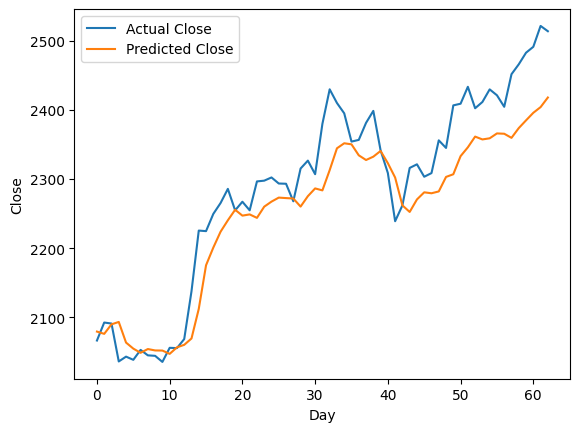

In [85]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()
